In [1]:
# Make sure that the necessary packages are installed
import sys
# !{sys.executable} -m pip -q install --upgrade pip
# !{sys.executable} -m pip -q install numpy matplotlib

In [2]:
# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from matplotlib import cm, colors

# Numerical and array operations
import numpy as np

# Format the output
from IPython.display import display, Markdown, Latex

## Function To Reconstruct The 3D Pattern From 2D Slices
Summing:
$$G(\phi, \theta) = G_H(\phi) + G_V(\theta)$$
Cross weighted:
$$G(\phi, \theta) = \dfrac{G_H(\phi)\cdot w_1 + G_V(\theta)\cdot w_2}{\sqrt{w_1^2 + w_2^2}}$$
Inspired by the MATLAB function [patternFromSlices](https://se.mathworks.com/help//antenna/ref/patternfromslices.html)

In [3]:
def pattern3D(vertical_slice, horizontal_slice, cross_weighted=True):
    # Find the maximum value to use it in the normalization
    max_directivity = max(np.amax(vertical_slice), np.amax(horizontal_slice))
    
    # Normalize the slices
    v_slice_normalized = vertical_slice - max_directivity
    h_slice_normalized = horizontal_slice - max_directivity
    
    # Create the grid points from the slices
    v_slice_grid_dB, h_slice_grid_dB = np.meshgrid(v_slice_normalized, h_slice_normalized)
    
    if cross_weighted:
        # Linearize to calculate the weights
        v_slice_lin = np.power(10.0, v_slice_grid_dB/10.0)
        h_slice_lin = np.power(10.0, h_slice_grid_dB/10.0)
    
        # Calculate the weights
        w1 = v_slice_lin*(1.0 - h_slice_lin)
        w2 = h_slice_lin*(1.0 - v_slice_lin)
    
        pattern = np.add(h_slice_grid_dB*w1, v_slice_grid_dB*w2)/np.sqrt(np.add(np.power(w1, 2.0), np.power(w2, 2.0)))
        pattern[np.logical_and(w1 == 0, w2 == 0)] = 0
    else:
        pattern = np.add(v_slice_grid_dB, h_slice_grid_dB) # Use the summing method
    
    return pattern + max_directivity

## Function To Calculate The Antenna Directivity
Directivity _(Not finished writing the explanation, so do not care what is written here in markdown.)_
$$\iint_0^{\pi}(S21)\sin{\theta}\,d\theta\,d\phi$$

In [4]:
def directivity(pattern_front, pattern_back, theta, angle_steps):
    # Linearize the pattern arrays
    pat3D_lin = np.power(10.0, pattern_front/10.0)
    pat3D_lin_back = np.power(10.0, pattern_back/10.0)

    # Calculate the intergals
    I_front = np.sum(np.multiply(pat3D_lin, np.sin(np.deg2rad(theta))))*np.deg2rad(angle_steps[0])*np.deg2rad(angle_steps[1])
    I_back = np.sum(np.multiply(pat3D_lin_back, np.sin(np.deg2rad(theta))))*np.deg2rad(angle_steps[0])*np.deg2rad(angle_steps[1])

    # Directivity calculation
    D = 4.0*np.pi*pat3D_lin/(I_front + I_back)
    D_dB = np.amax(10.0*np.log10(D))
    
    return round(D_dB, 2), 10.0*np.log10(D)

## Import The Measured Data
We read the raw data files and then we store the values to the corresponding variables.
* `v_slice_dB` contains the S21 data, in dB, for the slice with the slot edges faccing rightwards
* `h_slice_dB` contains the S21 data, in dB, for the slice with the slot edges faccing upwards
* `theta` is an array of the measurement angles for the vertical slice
* `phi` is an array of the measurement angles for the horizontal slice

Theta is normally $\theta = 90 - elevation$. In our case we are going to interpolate the corresponding data so we need the angle exactly as imported. This conversion will be done in later.

In [5]:
vertical_slice = np.loadtxt('Raw Data/Antenna Pattern/Slot_Side-Vertical_Slice.txt')
horizontal_slice = np.loadtxt('Raw Data/Antenna Pattern/Slot_Up-Horizontal_Slice.txt')

v_slice_dB = np.asarray([s21[1] for s21 in vertical_slice])
theta = np.asarray([angle[0] for angle in vertical_slice])

h_slice_dB = np.asarray([s21[1] for s21 in horizontal_slice])
phi = np.asarray([angle[0] for angle in horizontal_slice])

THETA_STEP = abs(theta[0] - theta[1])
PHI_STEP = abs(phi[0] - phi[1])

### Interpolate The Vertical Slice Data
Interpolation is required for the vertical slice S21 values, since the measurement was taken with a step of 2 degrees in order to get it faster, while the horizontal slice values where measured with a 1 degree step.

In [6]:
v_slice_interp_dB = np.interp(range(-90, 91), theta, v_slice_dB) # Interpolate the values, since the vertical slice was taken with a 2 degree step, instead of 1 degree
theta = 90.0 - np.arange(-90, 91, 1) # Renew theta to account for interpolation
THETA_STEP = abs(theta[0] - theta[1]) # Update the new step

## Simulate A Back Lobe
The measurements were only taken for the front facing side of the antenna, _(copper area)_, so we have to simulate a back lobe. We do that by deducting a certain amount of power, through the variable `back_level_dB`, from the existing front facing S21 values. The deduction is explained because the values are in dB.

In [7]:
back_level_dB = 16

v_slice_back_dB = [s21 - back_level_dB for s21 in v_slice_interp_dB]
h_slice_back_dB = [s21 - back_level_dB for s21 in h_slice_dB]

## Calculate The 3D Pattern and Directivity


In [8]:
pat3D = pattern3D(v_slice_interp_dB, h_slice_dB) # 3D pattern from the measurements
pat3D_back = pattern3D(v_slice_back_dB, h_slice_back_dB) # Simulated 3D pattern for the back lobe

pat3D_summing = pattern3D(v_slice_interp_dB, h_slice_dB, False)
pat3D_back_summing = pattern3D(v_slice_back_dB, h_slice_back_dB, False)

D_cross, D_cross_array = directivity(pat3D, pat3D_back, theta, [THETA_STEP, PHI_STEP])
D_summing, D_summing_array = directivity(pat3D_summing, pat3D_back_summing, theta, [THETA_STEP, PHI_STEP])

# Display output as markdown formatted
display(Markdown('### Calculated Directivity \n A simulated back lobe with a level of **_' + str(back_level_dB) + ' dB_** was used in the calculations.'))
display(Markdown('Based on the Cross-Weighted method the directivity is **_' + str(round(D_cross, 2)) + ' dB_**, while using the Summing method it is **_' + 
                 str(round(D_summing, 2)) + ' dB_**'))

### Calculated Directivity 
 A simulated back lobe with a level of **_16 dB_** was used in the calculations.

Based on the Cross-Weighted method the directivity is **_5.87 dB_**, while using the Summing method it is **_6.28 dB_**

## 3D Pattern Visualization
First we create a normalized array with the linear values of the 3D pattern points generated with the `pattern3D` function defined above. After that we create a grid of the $\phi = azimuth\; angle$ and $\theta = 90 - elevation\; angle$ angles. The conversion between spherical coordinates and cartesian is done as follows:
$$X = R\cos{\phi}\cos{\theta}$$
$$Y = R\cos{\phi}\sin{\theta}$$
$$Z = R\sin{\theta}$$
with $R = \text{pat3D_lin}$, $\phi = \text{phi_grid}$ and $\theta = \text{theta_grid}$.

In [9]:
# Linearized array for the cross-weighted method
pat3D_lin = np.power(10.0, pat3D/10.0)
pat3D_lin_norm = pat3D_lin/np.amax(pat3D_lin) # Normalized pattern array with linear values

# Linearized array for the summing method
pat3D_summing_lin = np.power(10.0, pat3D_summing/10.0)
pat3D_summing_lin_norm = pat3D_summing_lin/np.amax(pat3D_summing_lin)

# Create an angle grid
phi_grid, theta_grid = np.meshgrid(np.deg2rad(phi), np.deg2rad(theta))

# Cartesian coordinates of the pattern
X = pat3D_lin_norm*np.cos(phi_grid)*np.cos(theta_grid)
Y = pat3D_lin_norm*np.cos(phi_grid)*np.sin(theta_grid)
Z = pat3D_lin_norm*np.sin(phi_grid)

X_summing = pat3D_summing_lin_norm*np.cos(phi_grid)*np.cos(theta_grid)
Y_summing = pat3D_summing_lin_norm*np.cos(phi_grid)*np.sin(theta_grid)
Z_summing = pat3D_summing_lin_norm*np.sin(phi_grid)

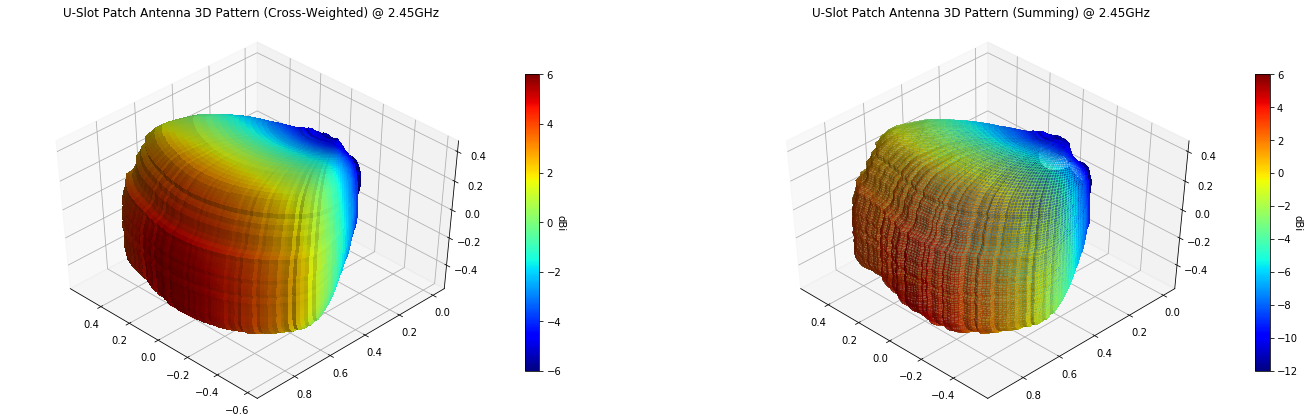

In [10]:
# Create the figure and the space
fig = plt.figure(figsize=(24, 15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax_summing = fig.add_subplot(2, 2, 2, projection='3d')

# Plot the pattern
plot = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.jet(Y),
                       linewidth=0, antialiased=False)

plot = ax_summing.plot_surface(X_summing, Y_summing, Z_summing, 
                               rstride=1, cstride=1, facecolors=plt.cm.jet(Y_summing),
                               linewidth=0, antialiased=False, alpha=0.5)

# Add colorbars to plots
color_map = cm.ScalarMappable(cmap=cm.jet)
color_map.set_array(D_cross_array)
color_map.set_clim(-6, 6)
cross_colorbar = fig.colorbar(color_map, ax=ax, shrink=0.8)
cross_colorbar.set_label('dBi', rotation=270)

color_map = cm.ScalarMappable(cmap=cm.jet)
color_map.set_array(D_summing_array)
color_map.set_clim(-12, 6)
summing_colorbar = fig.colorbar(color_map, ax=ax_summing, shrink=0.8)
summing_colorbar.set_label('dBi', rotation=270)

# Change the view angle and the title
ax.view_init(elev=45, azim=135)
ax.set_title('U-Slot Patch Antenna 3D Pattern (Cross-Weighted) @ 2.45GHz', pad=50)

ax_summing.view_init(45, 135)
ax_summing.set_title('U-Slot Patch Antenna 3D Pattern (Summing) @ 2.45GHz', pad=50)

# Draw the surface
plt.show()